# Explainability


In [ ]:
import sys

sys.path.append("..")

In [ ]:
import numpy as np
import torch

from agents.drl_agent import DRLAgent
from config import config
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from environments.env_stock_trading import StockTradingEnvWrapper
from explainability.shap_explainability import ShapExplainer
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.shap_visualiser import ShapVisualiser

In [ ]:
USE_CASE = "portfolio-optimisation"

In [ ]:
import os

if not os.path.exists(f"../{config.PLOT_DIR}/{USE_CASE}"):
    os.makedirs(f"../{config.PLOT_DIR}/{USE_CASE}")

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    "../" + config.DATA_DIR, config.TICKERS_NAME
)

In [ ]:
if USE_CASE == "stock-trading":
    environment = StockTradingEnvWrapper(
        train_data, trade_data, config.ENVIRONMENT_COLUMNS
    )
elif USE_CASE == "portfolio-optimisation":
    environment = PortfolioOptimisationEnvWrapper(
        train_data, trade_data, config.ENVIRONMENT_COLUMNS
    )

Environment successfully created with 
	Stock dimension: 5 
	State space: 14


## Load the results of a DRL agent


In [ ]:
model_name = "a2c"

env_train = environment.get_train_env()
gym_env, _ = environment.get_trade_env()

agent = DRLAgent()

model = agent.get_model(
    model_name,
    environment=env_train,
    directory=f"../{config.LOGS_DIR}/{USE_CASE}/{config.TICKERS_NAME}",
    use_case=USE_CASE,
)

print(f"Loading model: {model_name.upper()}")
trained_model = agent.load_model(
    model_name,
    f"../{config.MODELS_DIR}/{USE_CASE}",
    config.TICKERS_NAME,
)

policy = trained_model.policy

print(f"Evaluating model: {model_name.upper()}")
df_account, df_actions = agent.predict(trained_model, gym_env)

Model arguments: {'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Loading model: A2C
Model successfully loaded from ../models/portfolio-optimisation/test_a2c
Evaluating model: A2C


## SHAP


In [ ]:
shap_explainer = ShapExplainer()

In [ ]:
state_space = shap_explainer.build_state_space(
    trade_data, columns=config.ENVIRONMENT_COLUMNS
)

action_space = shap_explainer.build_action_space(df_actions)

In [ ]:
X_train, X_test, y_train, y_test = shap_explainer.split_data(
    state_space, action_space
)

### Proxy SHAP

Use a Random Forest as a proxy model to explain the agent's policy, given the environment representation and the actions taken by the agent at each time step.


In [ ]:
rf_model = shap_explainer.build_proxy_explanation_model(
    X_train, y_train, find_best_params=False
)

In [ ]:
explainer = shap_explainer.build_proxy_explainer(rf_model)

In [ ]:
shap_values = shap_explainer.compute_shap_values(explainer, X_test)

In [ ]:
shap_interaction_values = shap_explainer.compute_shap_interaction_values(
    explainer, X_test
)

In [ ]:
shap_visualiser = ShapVisualiser(
    shap_values, action_space, X_test, shap_interaction_values
)

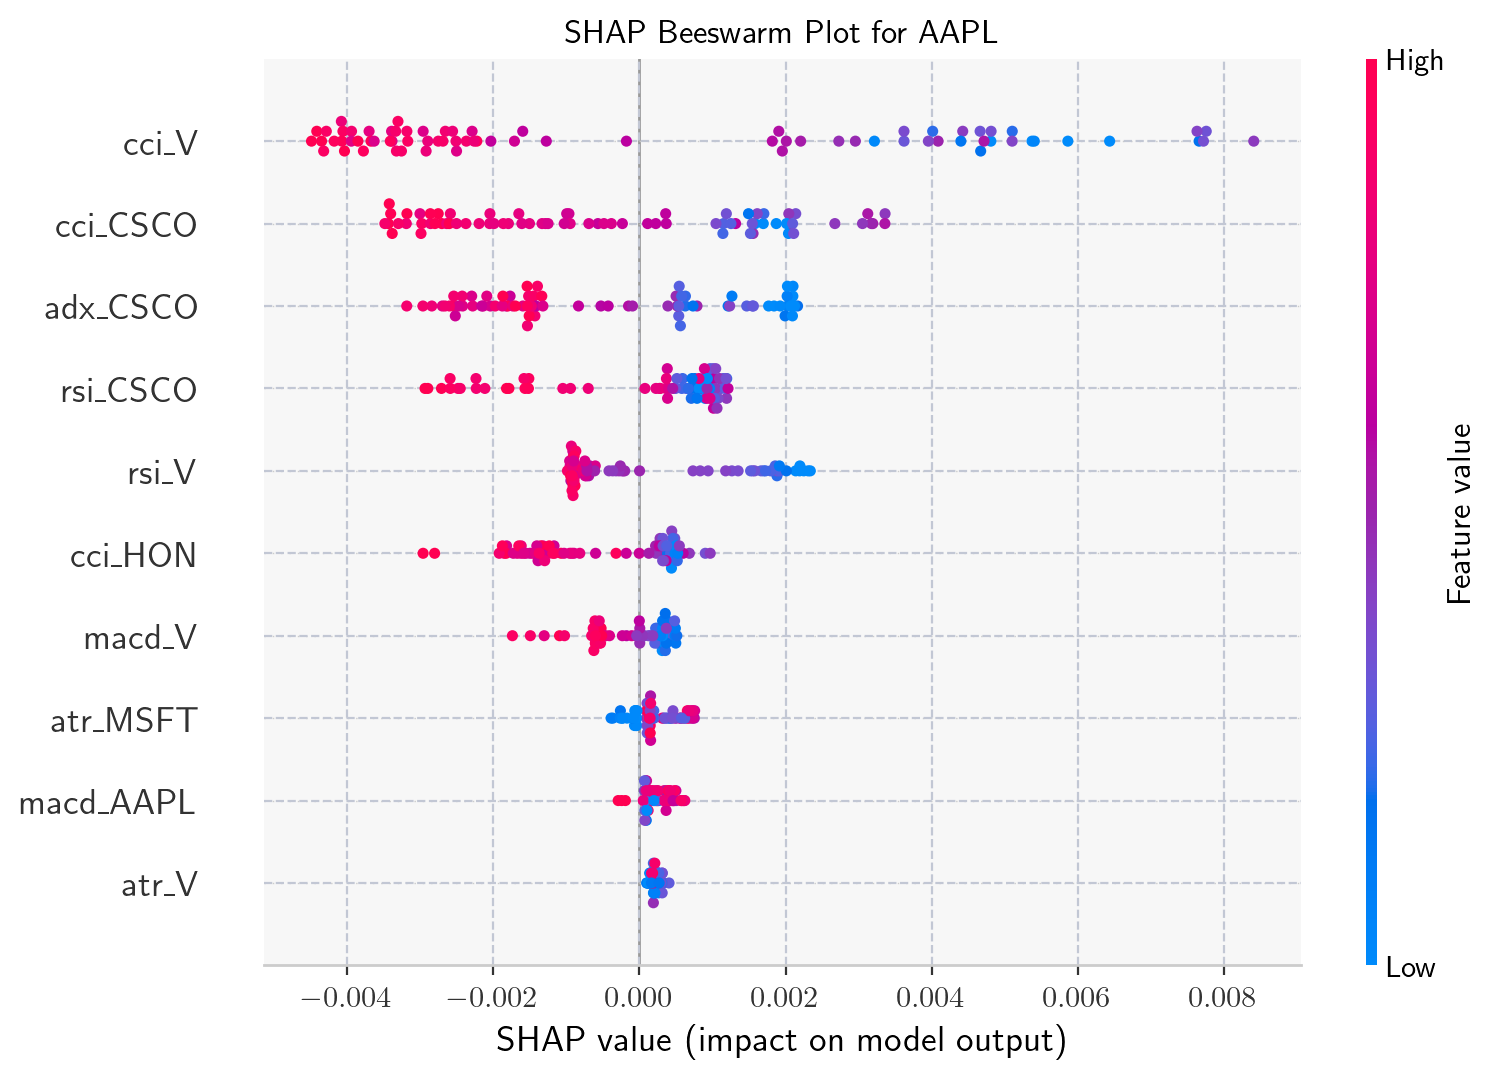

In [ ]:
index = 0
shap_visualiser.beeswarm_plot(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", f"{config.TICKERS_NAME}_proxy"
)

In [ ]:
shap_visualiser.force_plot(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", f"{config.TICKERS_NAME}_proxy"
)

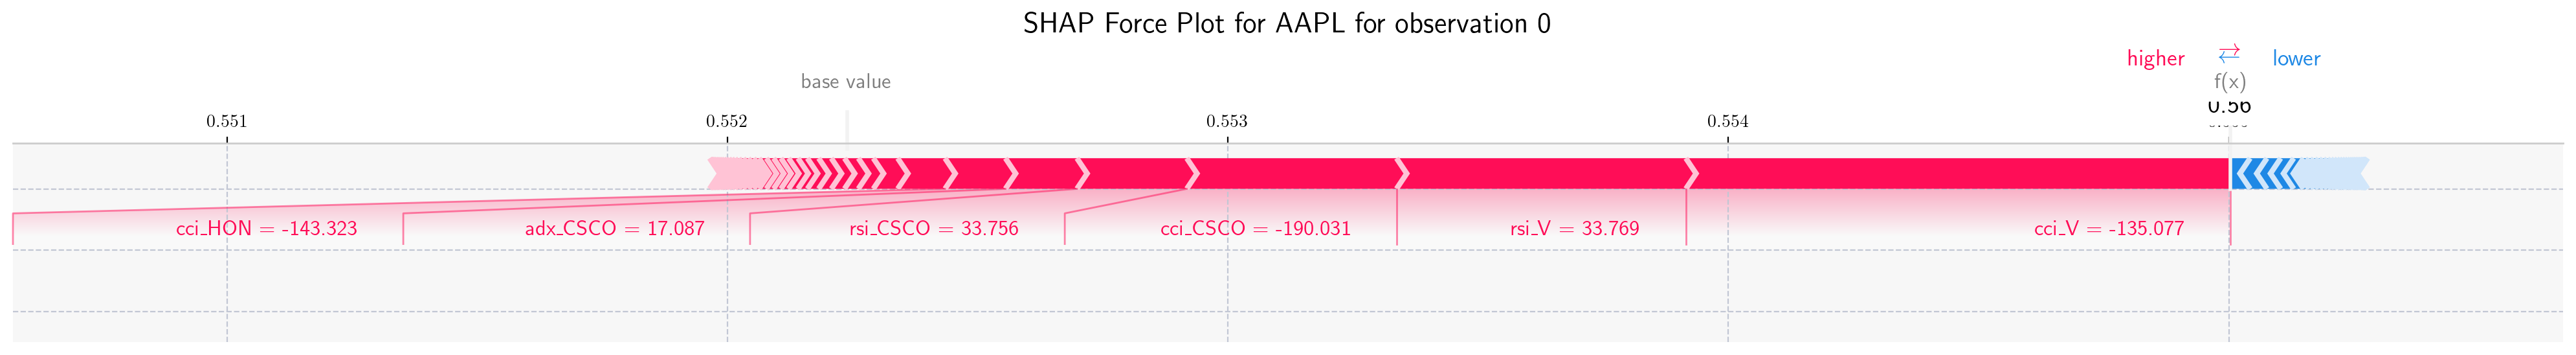

In [ ]:
obs = 0
shap_visualiser.force_plot_single_obs(
    index,
    obs,
    f"../{config.PLOT_DIR}/{USE_CASE}",
    f"{config.TICKERS_NAME}_proxy",
)

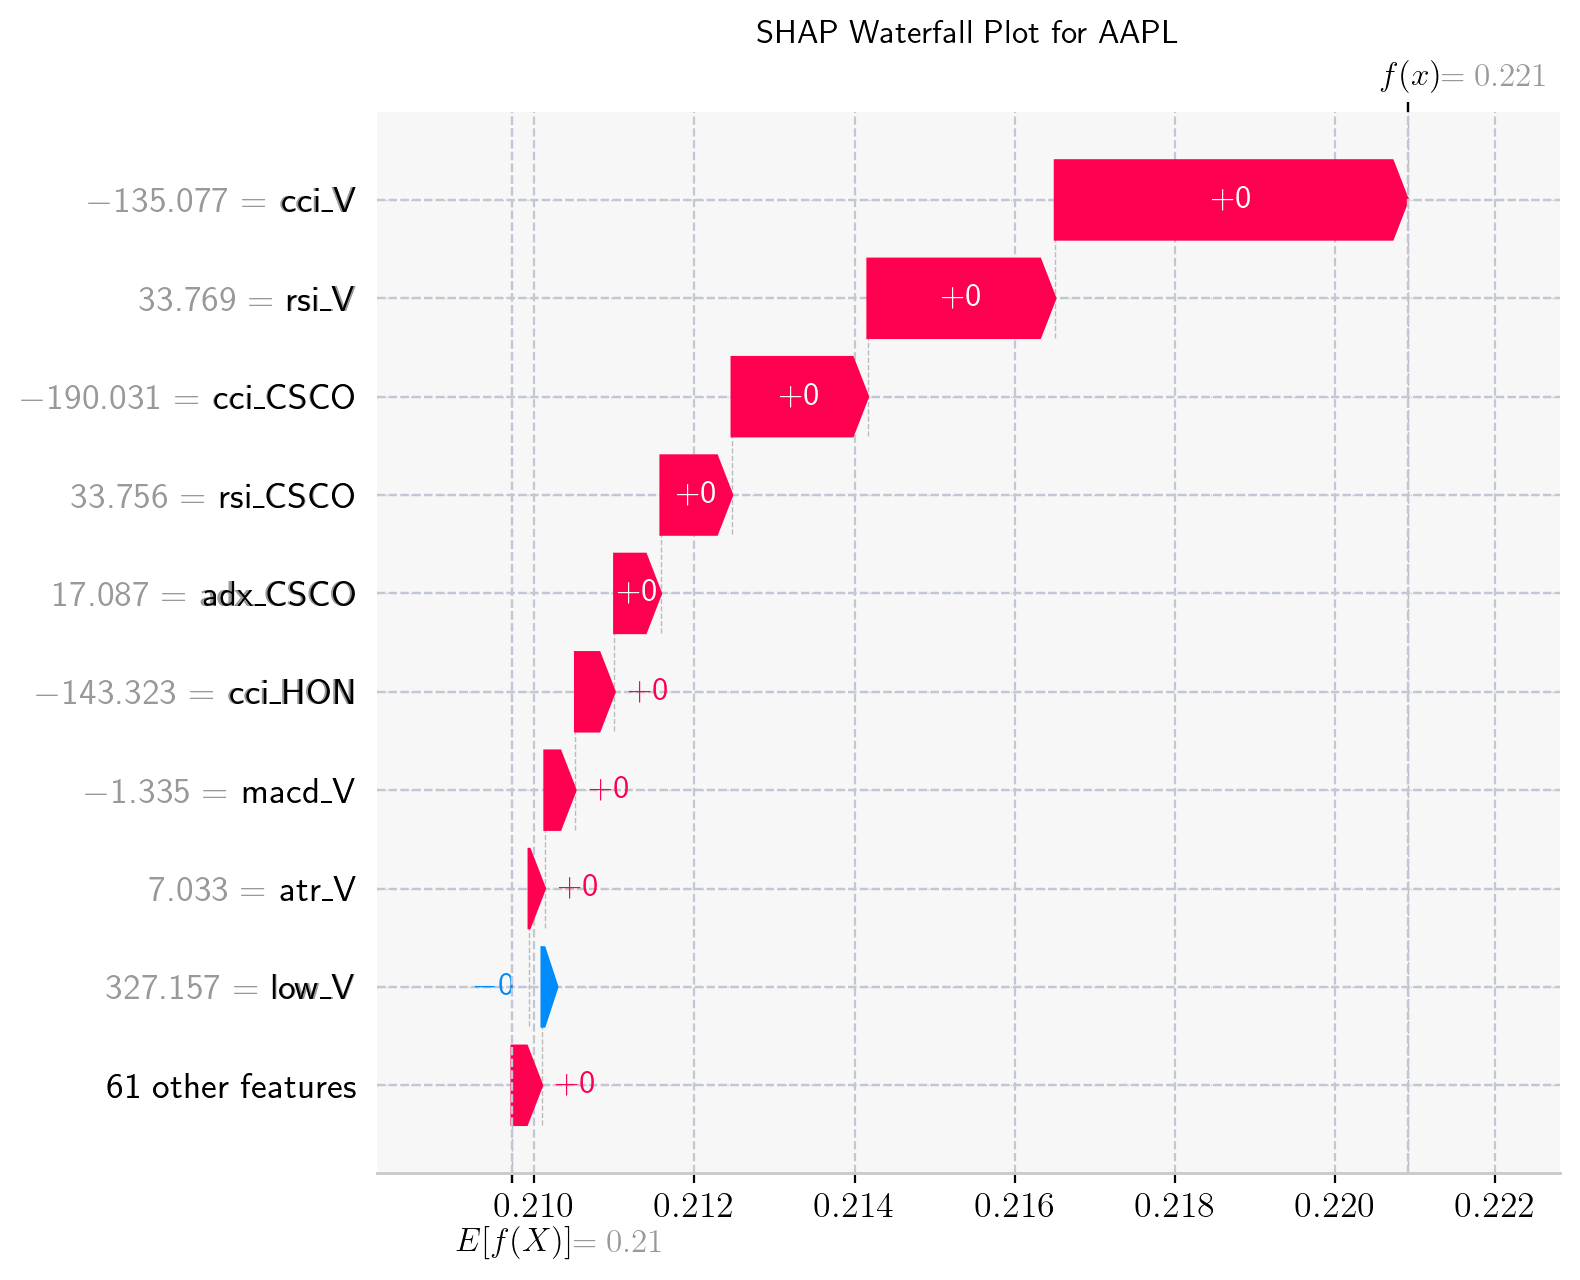

In [ ]:
shap_visualiser.waterfall_plot_single_obs(
    index,
    obs,
    f"../{config.PLOT_DIR}/{USE_CASE}",
    f"{config.TICKERS_NAME}_proxy",
)

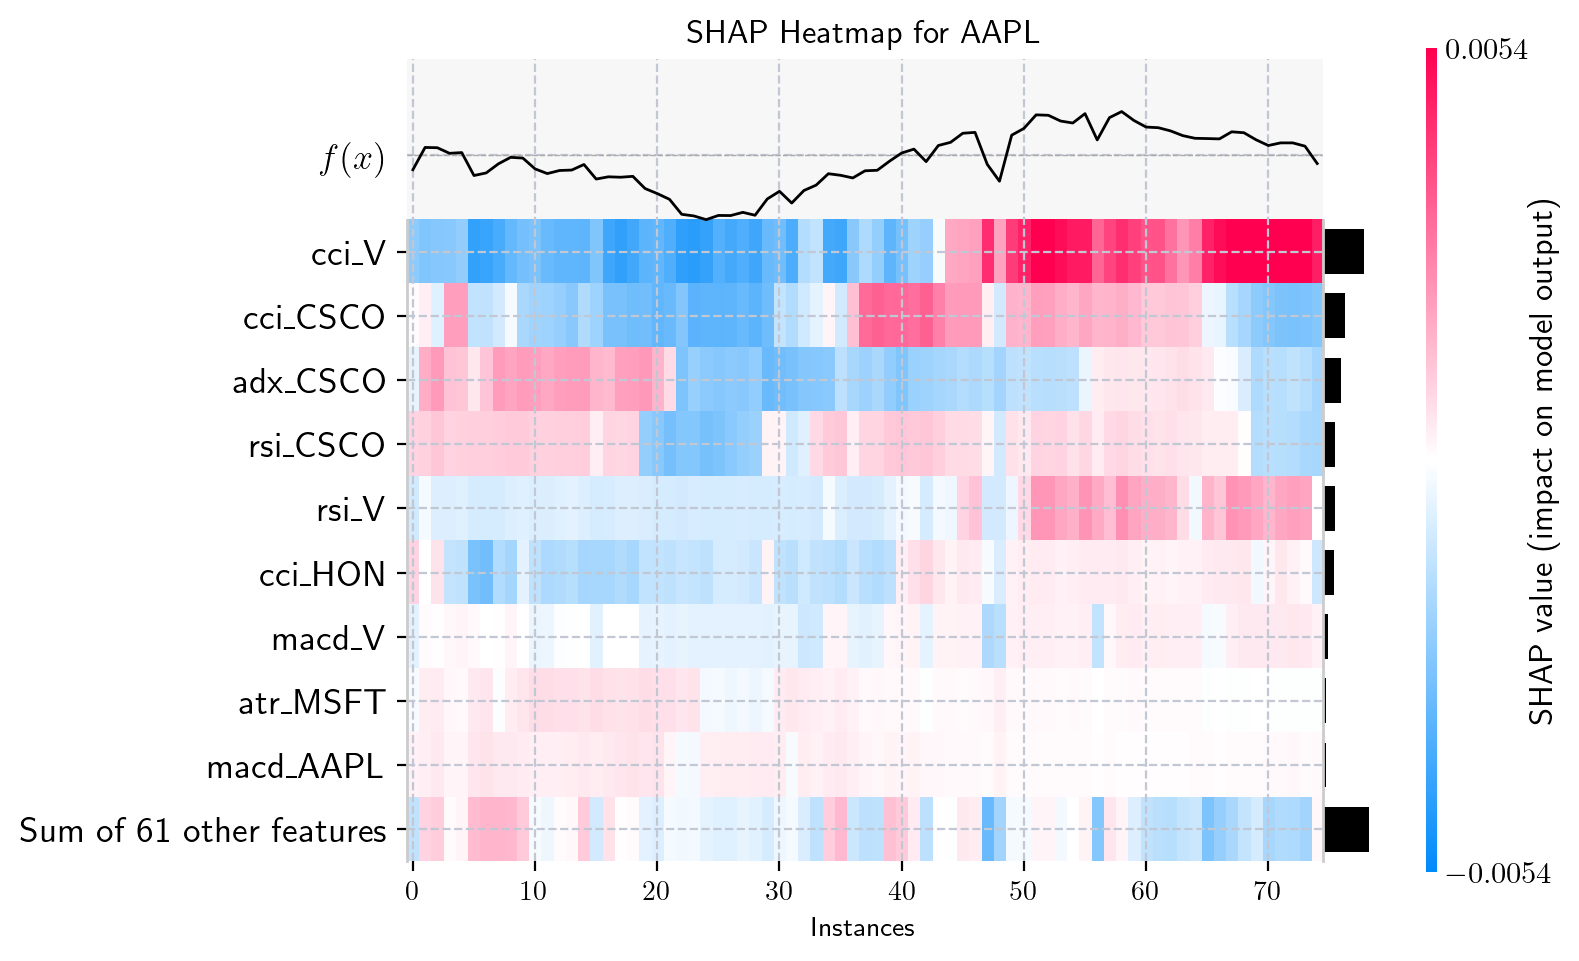

In [ ]:
shap_visualiser.heatmap(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", f"{config.TICKERS_NAME}_proxy"
)

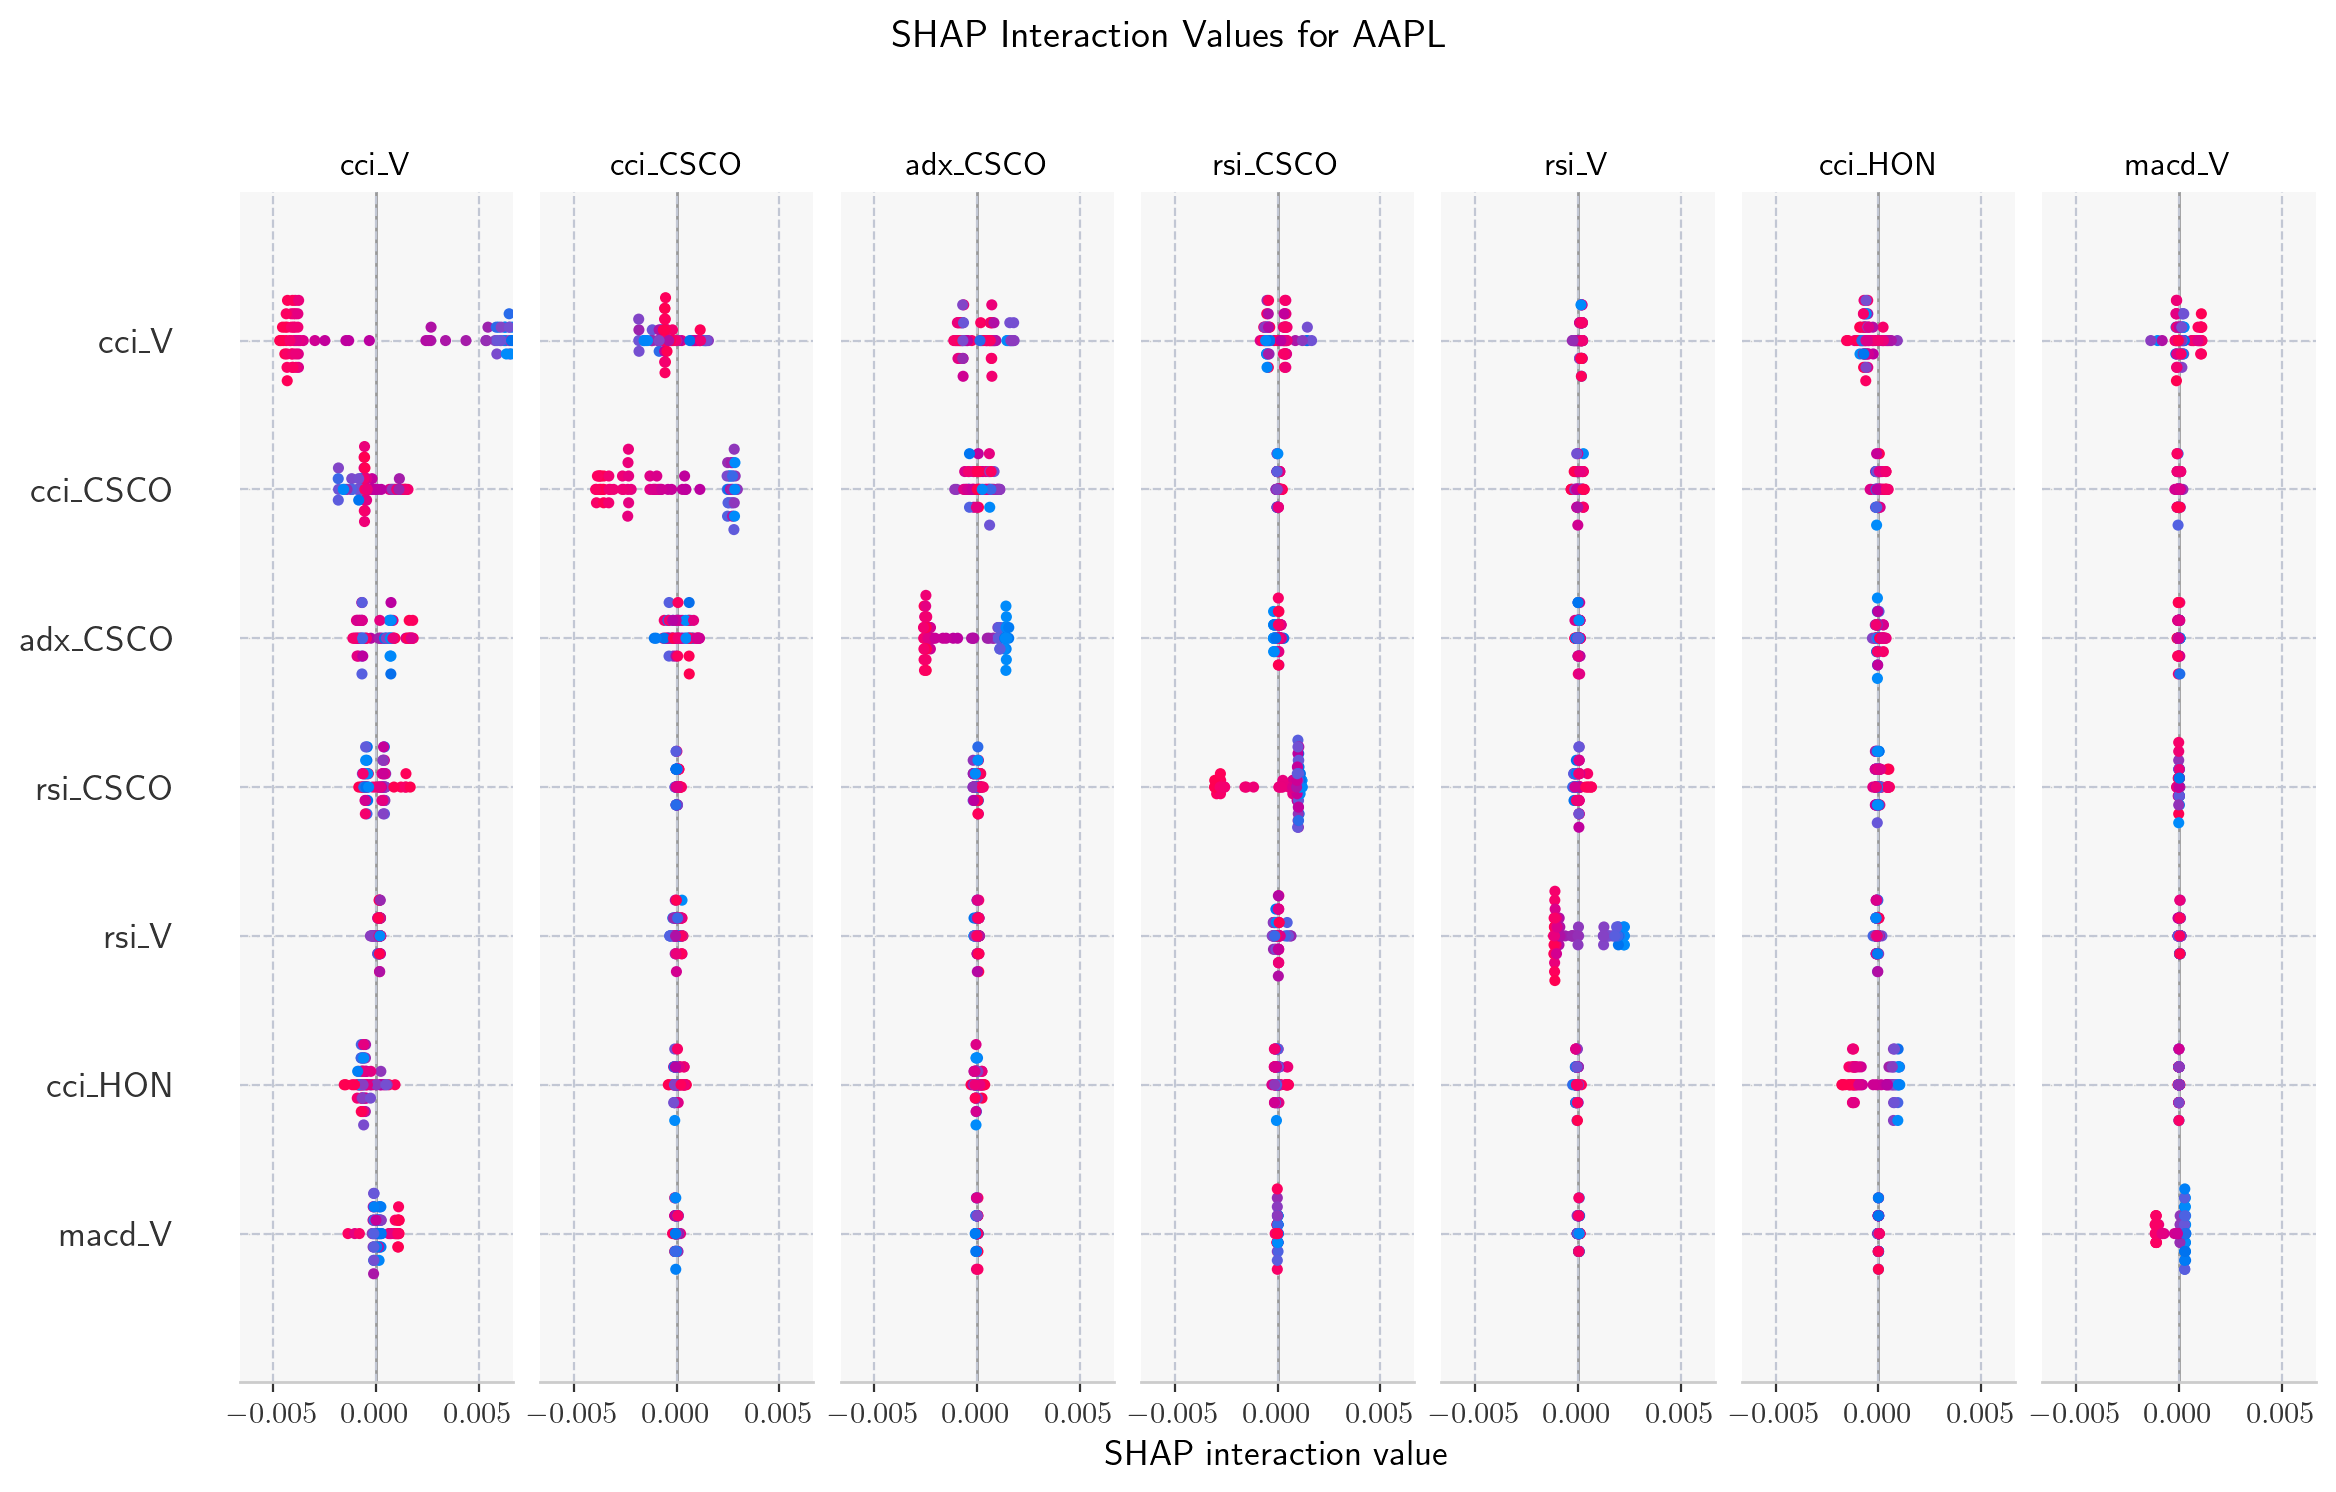

In [ ]:
shap_visualiser.interaction_plot(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", f"{config.TICKERS_NAME}_proxy"
)

### Kernel SHAP

Use Kernel Explainer to explain the agent's actions given the policy.


In [ ]:
## Prediction function for the policy
def predict(states: list) -> np.ndarray:
    """
    Predict the action for a given state using the policy.
    """
    with torch.no_grad():
        states_tensor = torch.tensor(states, dtype=torch.float32)
        action, _ = policy.predict(
            states_tensor.reshape(
                -1, environment.state_space, environment.stock_dim
            ).numpy()
        )
        return action

In [ ]:
explainer = shap_explainer.build_kernel_explainer(predict, X_train)

Using 299 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = shap_explainer.compute_shap_values(explainer, X_test)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
shap_visualiser = ShapVisualiser(shap_values, action_space, X_test)

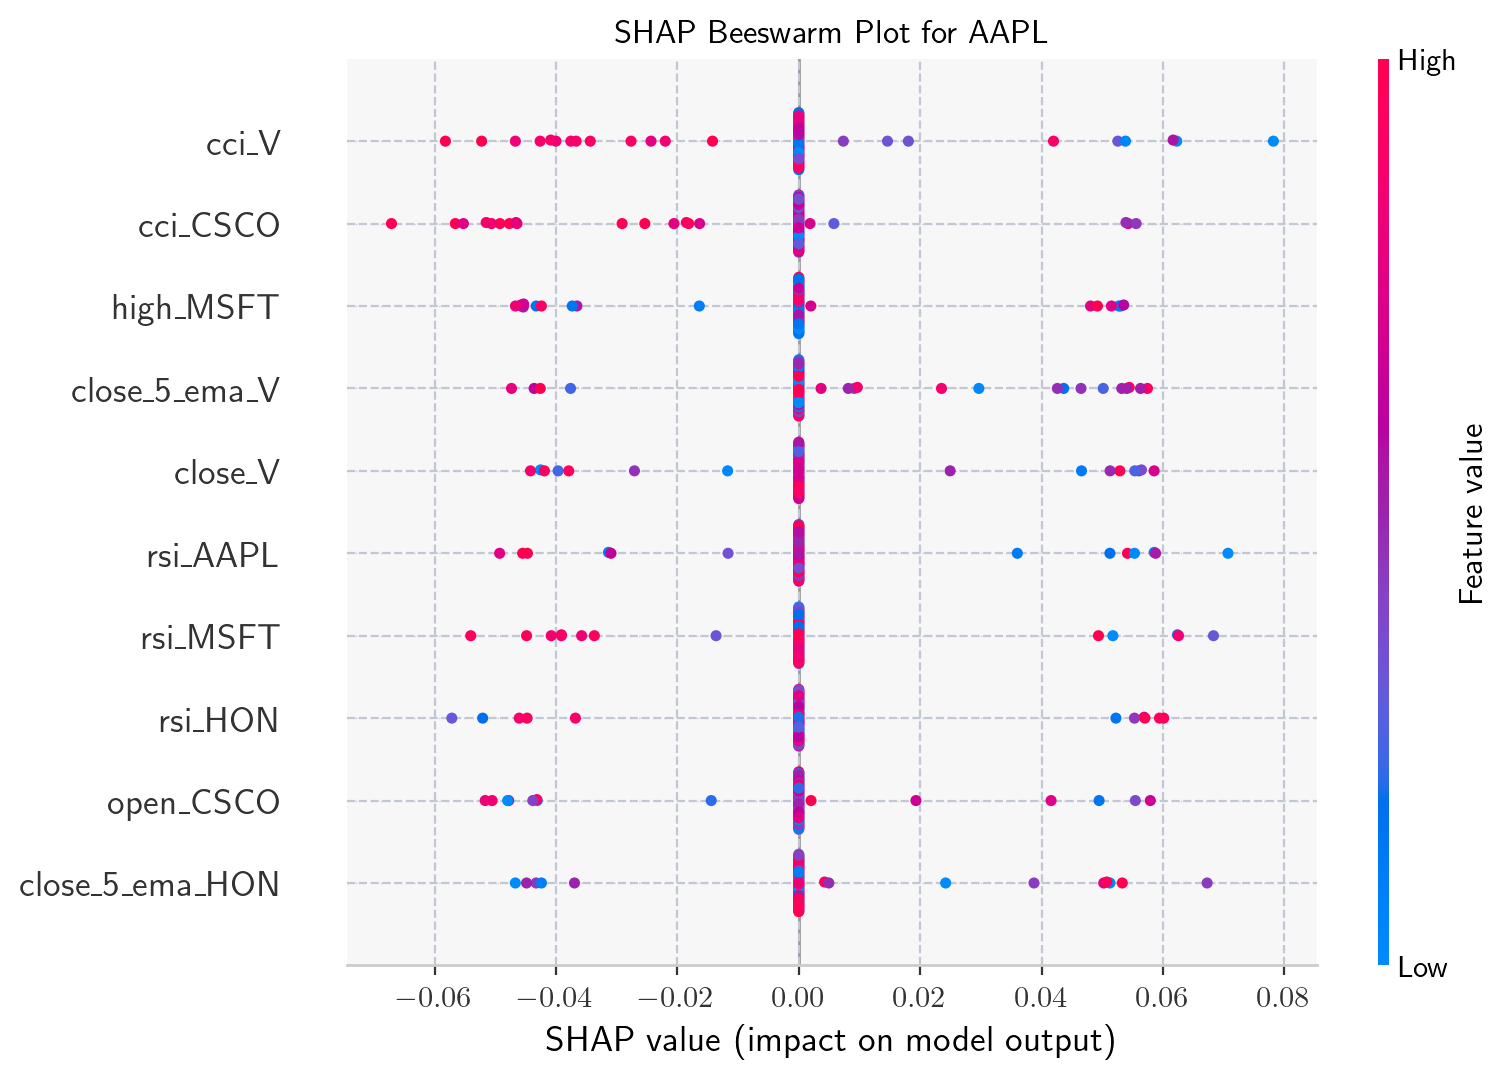

In [ ]:
index = 0
shap_visualiser.beeswarm_plot(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", config.TICKERS_NAME
)

In [ ]:
shap_visualiser.force_plot(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", config.TICKERS_NAME
)

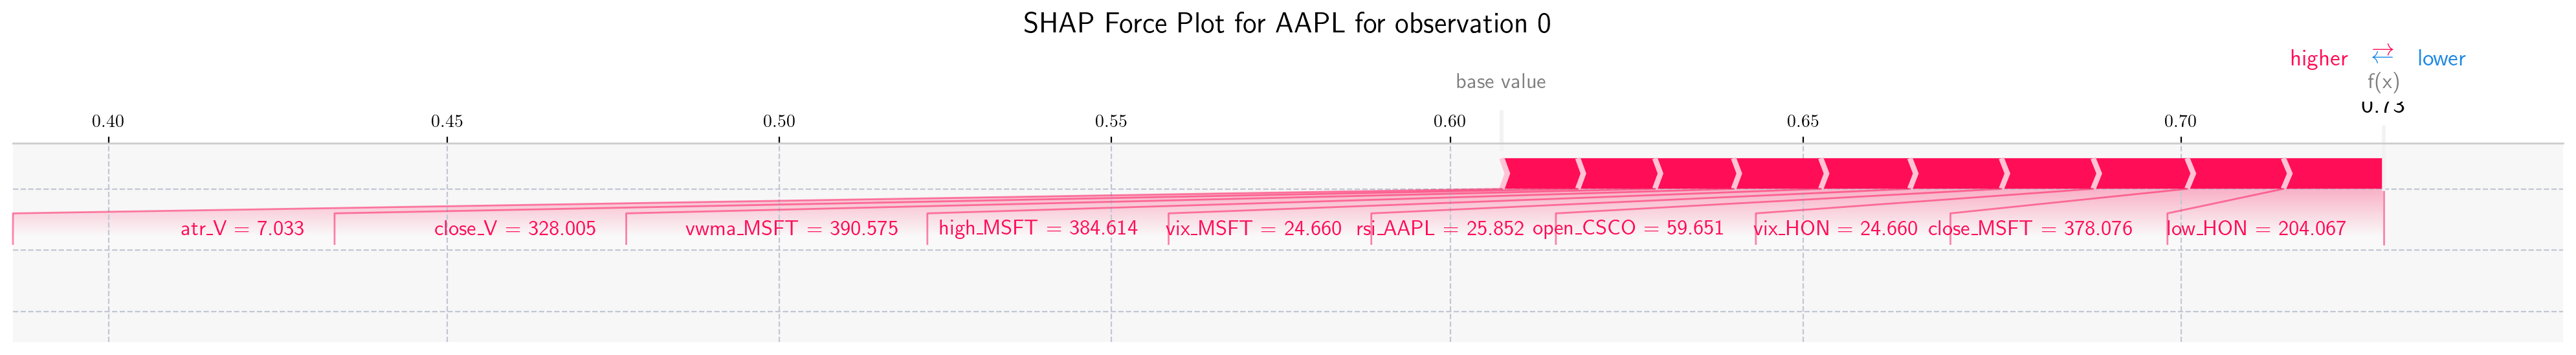

In [ ]:
obs = 0
shap_visualiser.force_plot_single_obs(
    index, obs, f"../{config.PLOT_DIR}/{USE_CASE}", config.TICKERS_NAME
)

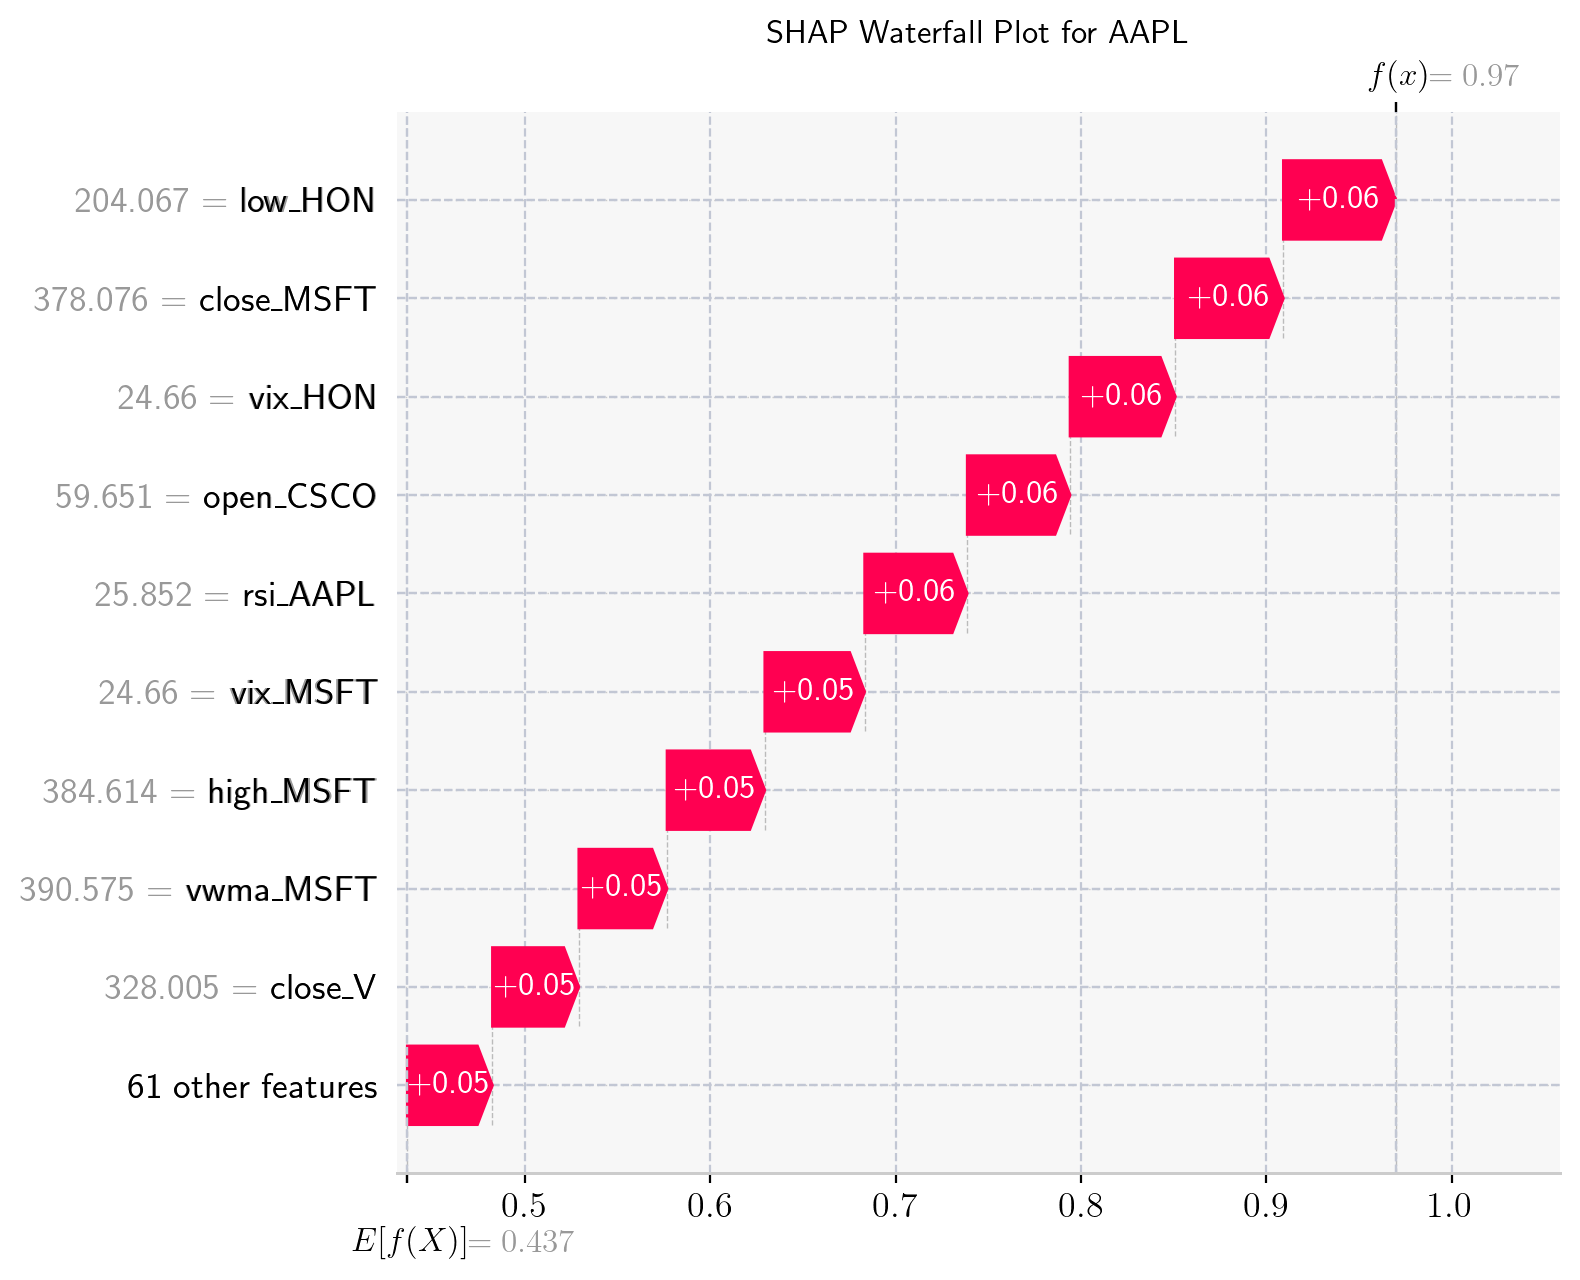

In [ ]:
shap_visualiser.waterfall_plot_single_obs(
    index, obs, f"../{config.PLOT_DIR}/{USE_CASE}", config.TICKERS_NAME
)

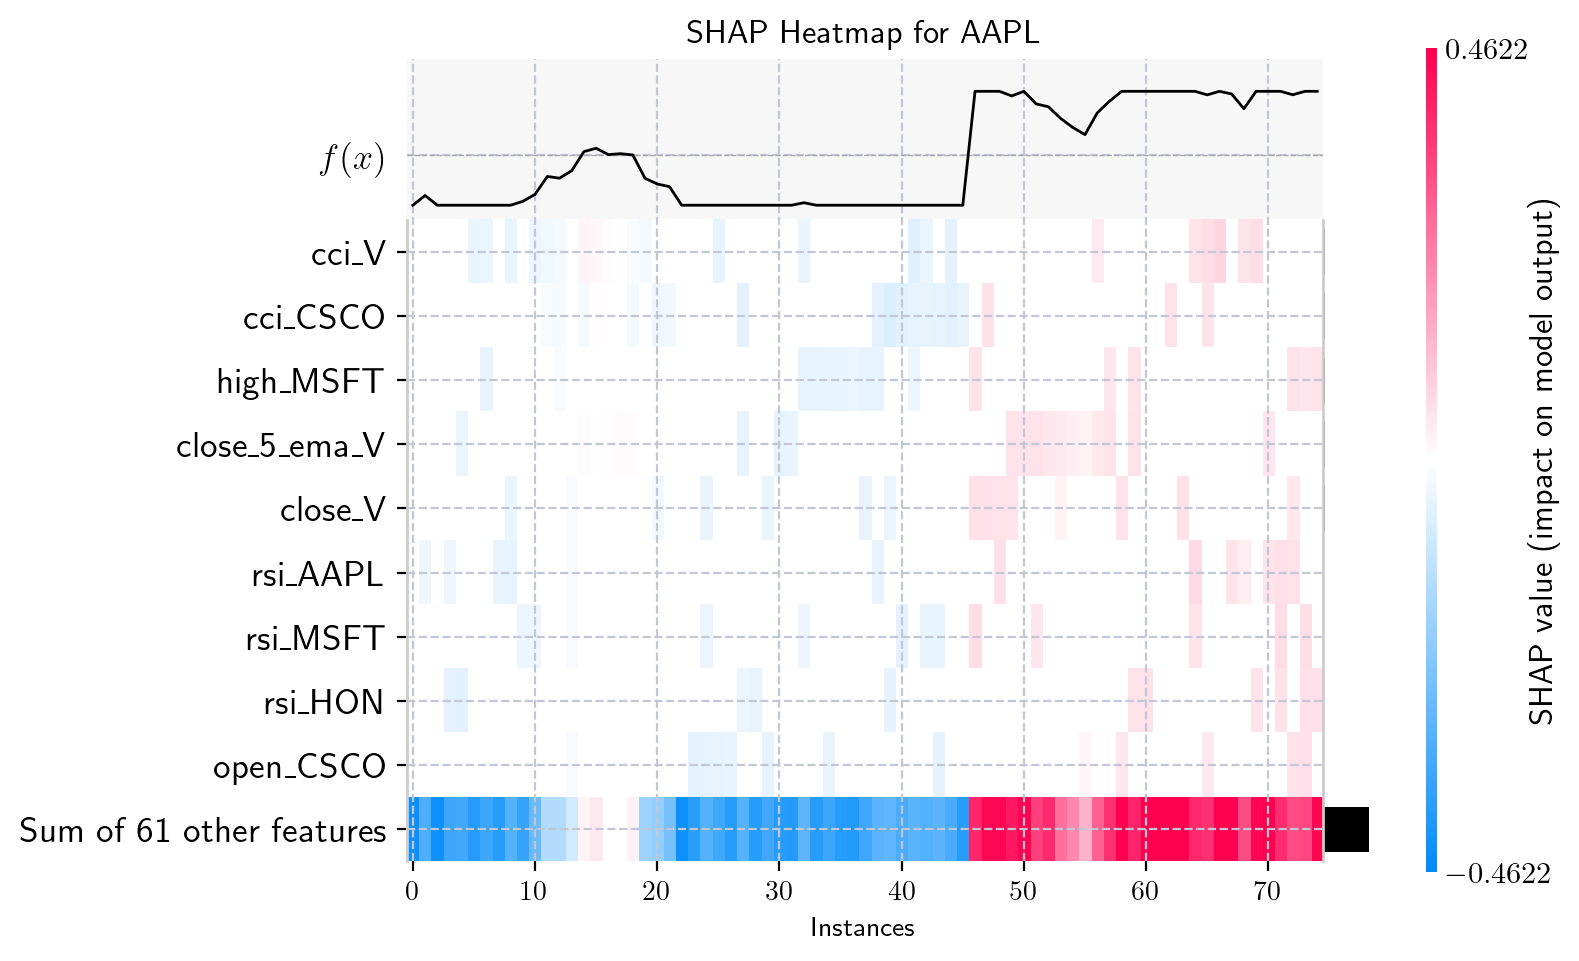

In [ ]:
shap_visualiser.heatmap(
    index, f"../{config.PLOT_DIR}/{USE_CASE}", config.TICKERS_NAME
)